In [1]:
!pip3 install pandas
!pip3 install seaborn
!pip3 install --upgrade tensorflow-gpu

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import pickle

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.losses import mse
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))

# Danmini Doorbell Data Pre-Processing

In [3]:
# Benign traffic

dd_benign = pd.read_csv('nbaiot/Danmini_Doorbell/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_dd_benign = dd_benign.copy(deep=True)

# Mirai

dd_mirai_ack = pd.read_csv('nbaiot/Danmini_Doorbell/mirai/ack.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_ack = dd_mirai_ack.copy(deep=True)

dd_mirai_scan = pd.read_csv('nbaiot/Danmini_Doorbell/mirai/scan.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_scan = dd_mirai_scan.copy(deep=True)

dd_mirai_syn = pd.read_csv('nbaiot/Danmini_Doorbell/mirai/syn.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_syn = dd_mirai_syn.copy(deep=True)

dd_mirai_udp = pd.read_csv('nbaiot/Danmini_Doorbell/mirai/udp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_udp = dd_mirai_udp.copy(deep=True)

dd_mirai_udpplain = pd.read_csv('nbaiot/Danmini_Doorbell/mirai/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_udpplain = dd_mirai_udpplain.copy(deep=True)

# Bashlite

dd_bashlite_combo = pd.read_csv('nbaiot/Danmini_Doorbell/gafgyt/combo.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_combo = dd_bashlite_combo.copy(deep=True)

dd_bashlite_junk = pd.read_csv('nbaiot/Danmini_Doorbell/gafgyt/junk.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_junk = dd_bashlite_junk.copy(deep=True)

dd_bashlite_scan = pd.read_csv('nbaiot/Danmini_Doorbell/gafgyt/scan.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_scan = dd_bashlite_scan.copy(deep=True)

dd_bashlite_udp = pd.read_csv('nbaiot/Danmini_Doorbell/gafgyt/udp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_udp = dd_bashlite_udp.copy(deep=True)

dd_bashlite_tcp = pd.read_csv('nbaiot/Danmini_Doorbell/gafgyt/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_tcp = dd_bashlite_udp.copy(deep=True)

In [4]:
scaler = MinMaxScaler()
df_dd_benign_norm = scaler.fit_transform(df_dd_benign)

df_dd_miraiack_norm = scaler.fit_transform(df_dd_mirai_ack)
df_dd_miraiscan_norm = scaler.fit_transform(df_dd_mirai_scan)
df_dd_miraisyn_norm = scaler.fit_transform(df_dd_mirai_syn)
df_dd_miraiudp_norm = scaler.fit_transform(df_dd_mirai_udp)
df_dd_miraiudpplain_norm = scaler.fit_transform(df_dd_mirai_udpplain)

df_dd_bashlitecombo_norm = scaler.fit_transform(df_dd_bashlite_combo)
df_dd_bashlitejunk_norm = scaler.fit_transform(df_dd_bashlite_junk)
df_dd_bashlitescan_norm = scaler.fit_transform(df_dd_bashlite_scan)
df_dd_bashliteudp_norm = scaler.fit_transform(df_dd_bashlite_udp)
df_dd_bashlitetcp_norm = scaler.fit_transform(df_dd_bashlite_tcp)

# Variational Autoencoder - Attack Detection

## Model

In [5]:
# Train set

len_benign = len(df_dd_benign_norm)
len_benign_train = int(0.7 * len_benign)
X_train_VAE = df_dd_benign_norm[:len_benign_train]

# Test set - 50% benign 50% attack

X_test_benign = df_dd_benign_norm[len_benign_train:]

len_attack_test = len(X_test_benign)
X_test_mirai_ack = df_dd_miraiack_norm[: int(len_attack_test / 10)]
X_test_mirai_scan = df_dd_miraiscan_norm[: int(len_attack_test / 10) + 1]
X_test_mirai_syn = df_dd_miraisyn_norm[: int(len_attack_test / 10)]
X_test_mirai_udp = df_dd_miraiudp_norm[: int(len_attack_test / 10) + 1]
X_test_mirai_udpplain = df_dd_miraiudpplain_norm[: int(len_attack_test / 10)]
X_test_bashlite_combo = df_dd_bashlitecombo_norm[: int(len_attack_test / 10) + 1]
X_test_bashlite_junk = df_dd_bashlitejunk_norm[: int(len_attack_test / 10)]
X_test_bashlite_scan = df_dd_bashlitescan_norm[: int(len_attack_test / 10) + 1]
X_test_bashlite_tcp = df_dd_bashlitetcp_norm[: int(len_attack_test / 10)]
X_test_bashlite_udp = df_dd_bashliteudp_norm[: int(len_attack_test / 10) + 1]

X_test_VAE = np.concatenate([X_test_benign, X_test_mirai_ack, X_test_mirai_scan, X_test_mirai_syn, X_test_mirai_udp,
                             X_test_mirai_udpplain, X_test_bashlite_combo, X_test_bashlite_junk, X_test_bashlite_scan,
                             X_test_bashlite_tcp, X_test_bashlite_udp])

Y_test_VAE = np.ones(len(X_test_VAE))
Y_test_VAE[:len(X_test_benign)] = 0

In [6]:
# Reparameterization trick

def sample(args):
    z_mean, z_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape = (batch, dim))
    
    return z_mean + K.exp(0.5 * z_var) * epsilon

# Sample the normally distributed z - mean + sigma * epsilon. The epsilon ensures the continuity of latent space and helps
# the network to keep correcting its parameters through backpropagation

In [7]:
# KL Loss function

def vae_loss(x, x_decoded_mean):
    # Compute the average MSE error, then scale it up (sum on all axes)
    
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    
    # Compute the KL loss
    
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.square(K.exp(z_var)), axis=-1)
    
    # Return the average loss over all 
    
    total_loss = K.mean(reconstruction_loss + kl_loss) # Total_loss = reconstruction_loss + kl_loss 
    return total_loss

# (1) Reconstruction Loss - Forces the encoder to generate latent features that minimize the reconstruction error, or else is
# penalized
# (2) KL Loss - Forces the distribution generated by the encoder to be similar to the prior probability of the input vector, 
# pushing latent feature space to normality

In [8]:
# Parameters

original_dim = X_train_VAE.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [9]:
# Encoder Model

inputs = Input(shape = input_shape, name = 'encoder_input')
x = Dense(intermediate_dim, activation = 'relu')(inputs)

z_mean = Dense(latent_dim, name = 'z_mean')(x)
z_var = Dense(latent_dim, name = 'z_var')(x)
z = Lambda(sample, output_shape = (latent_dim,), name = 'z')([z_mean, z_var])

encoder = Model(inputs, z, name = 'encoder')
encoder.summary()

# The encoder learns a function that takes an input array of size n and can generate two vectors that represents the
# parameters (mean and variance) of a distribution from which the latent vector is sampled.

# encoder(input_vector[]) => latent_v_mu[], latent_v_lvar[]
# So that - latent_v[0] ~  N(latent_v_mu[0], latent_v_lvar[0])
# and latent_v[1] ~  N(latent_v_mu[1], latent_v_lvar[1])

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 115)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 57)           6612        encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 38)           2204        dense[0][0]                      
__________________________________________________________________________________________________
z_var (Dense)                   (None, 38)           2204        dense[0][0]                      
____________________________________________________________________________________________

In [10]:
# Decoder model

latent_inputs = Input(shape = (latent_dim,), name = 'z_sampling')
x = Dense(intermediate_dim, activation = 'relu')(latent_inputs)
outputs = Dense(original_dim, activation = 'sigmoid')(x)

# Instantiate the decoder model

decoder = Model(latent_inputs, outputs, name = 'decoder')
decoder.summary()

# Transforms the latent feature space composed by distributions of mean and variance back to the original input vector

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 38)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 57)                2223      
_________________________________________________________________
dense_2 (Dense)              (None, 115)               6670      
Total params: 8,893
Trainable params: 8,893
Non-trainable params: 0
_________________________________________________________________


In [11]:
# VAE model

outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name = 'vae_mlp')

In [12]:
opt = optimizers.Adam(learning_rate = 0.0001, clipvalue = 0.5)

vae_model.compile(optimizer = opt, loss = vae_loss)
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 115)]             0         
_________________________________________________________________
encoder (Functional)         (None, 38)                11020     
_________________________________________________________________
decoder (Functional)         (None, 115)               8893      
Total params: 19,913
Trainable params: 19,913
Non-trainable params: 0
_________________________________________________________________


## Train

In [13]:
results = vae_model.fit(X_train_VAE, X_train_VAE,
                        shuffle = True,
                        epochs = 50,
                        batch_size = 50)

Train on 34683 samples
Epoch 1/50
34683/34683 [==============================] - 2s 57us/sample - loss: 321.0312
Epoch 2/50
34683/34683 [==============================] - 2s 54us/sample - loss: 37.0209
Epoch 3/50
34683/34683 [==============================] - 2s 51us/sample - loss: 25.4696
Epoch 4/50
34683/34683 [==============================] - 2s 53us/sample - loss: 20.4841
Epoch 5/50
34683/34683 [==============================] - 2s 54us/sample - loss: 17.2346
Epoch 6/50
34683/34683 [==============================] - 2s 53us/sample - loss: 14.8008
Epoch 7/50
34683/34683 [==============================] - 2s 51us/sample - loss: 12.9929
Epoch 8/50
34683/34683 [==============================] - 2s 53us/sample - loss: 11.4961
Epoch 9/50
34683/34683 [==============================] - 2s 54us/sample - loss: 10.4122
Epoch 10/50
34683/34683 [==============================] - 2s 54us/sample - loss: 9.4851
Epoch 11/50
34683/34683 [==============================] - 2s 54us/sample - loss: 8.77

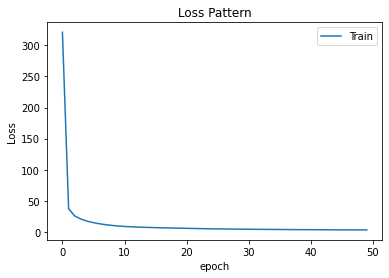

In [14]:
plt.plot(results.history['loss'])
plt.title('Loss Pattern')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right');
plt.show()

## Test

In [15]:
def get_error_term(v1, v2, _rmse = True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis = 1))
    
    return np.mean(abs(v1 - v2), axis = 1)

# Calculates the error between the original vector and the predicted one

In [16]:
X_train_pred = vae_model.predict(X_train_VAE)
error_vector = get_error_term(X_train_pred, X_train_VAE, _rmse=False)
error_thresh = np.quantile(error_vector, 0.999)

print(error_thresh)

# Measure the error between the train set and its output and generates an error vector representing the error of each term
# Find an extreme value on the vector to use as the error threshold

/home/andressa.amaral/.local/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


0.10895256250767621


In [17]:
X_pred_VAE = vae_model.predict(X_test_VAE)

# If the error of the vector is higher than the defined threshold it detects an attack

error_vector = get_error_term(X_pred_VAE, X_test_VAE, _rmse=False)
attacks = (error_vector > error_thresh)
print(attacks)

np.count_nonzero(attacks) / len(attacks) # Percentage of attacks

[False False False ...  True False  True]


0.4625967036663303

## Metrics

In [18]:
print(classification_report(Y_test_VAE, attacks, digits = 6))

              precision    recall  f1-score   support

         0.0   0.929336  0.998856  0.962843     14865
         1.0   0.998764  0.924050  0.959955     14865

    accuracy                       0.961453     29730
   macro avg   0.964050  0.961453  0.961399     29730
weighted avg   0.964050  0.961453  0.961399     29730



In [19]:
# Examinig the latent space generated by the encoder

X_encoded = encoder.predict(X_test_VAE)

pca = PCA(n_components=2)
X_analysis = pca.fit_transform(X_encoded)

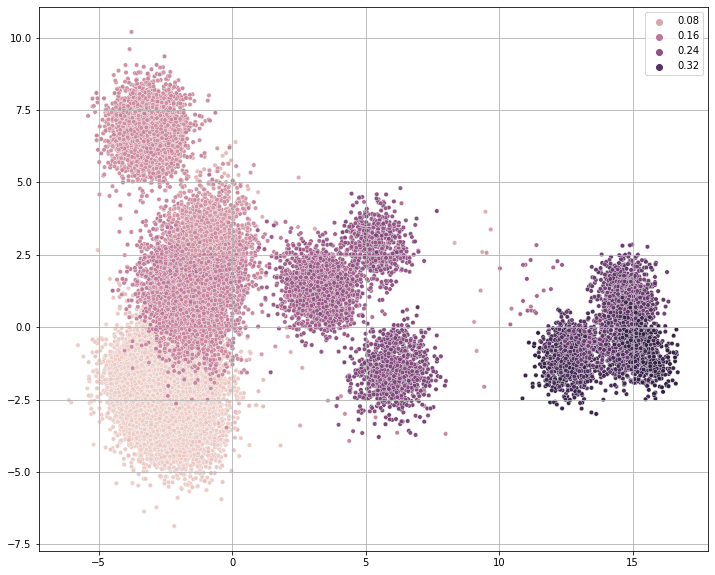

In [20]:
plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = error_vector)
plt.grid()
plt.show()

# Darker clusters indicate that the error is higher

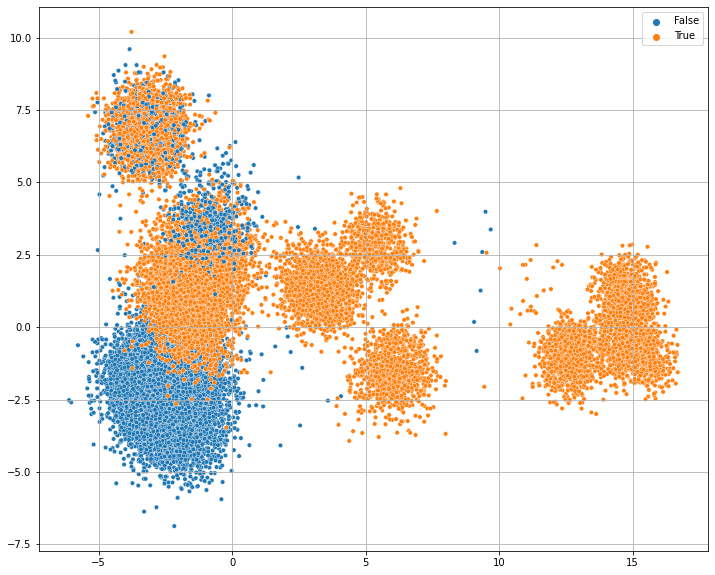

In [21]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = attacks)
plt.grid()
plt.show()

# Orange ones are anomalies

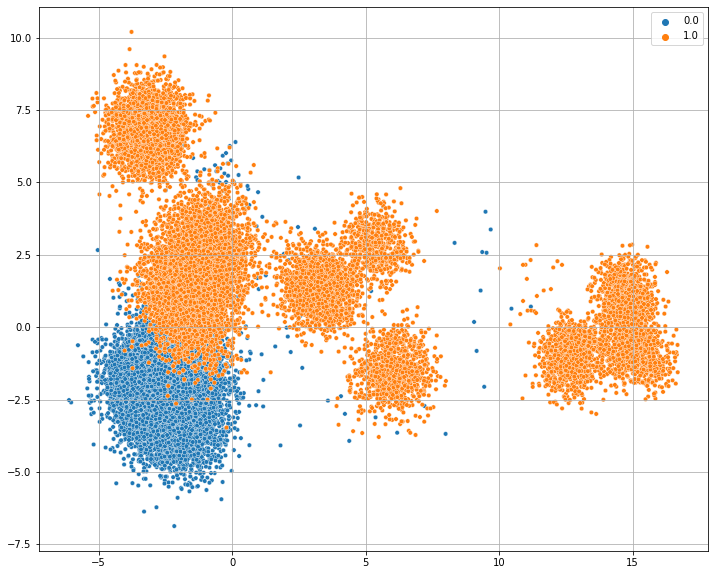

In [22]:
plt.figure(figsize = (12, 10))
sns.scatterplot(x = X_analysis[:, 0], y = X_analysis[:, 1], s = 20, hue = Y_test_VAE)
plt.grid()
plt.show()

# Ground truth